In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(1)
import random as rn
rn.seed(2)
import tensorflow as tf
tf.random.set_seed(3)
import pandas as pd
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import confusion_matrix
from keras.preprocessing import sequence
#from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SpatialDropout1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
#from keras.layers.merge import Concatenate
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
import pickle
import unidecode

In [2]:
corpus_file = pd.read_csv(r"C:\Users\Mithun\Downloads\cleancorpus_5.csv")
corpus_file = corpus_file[~corpus_file['cleanLemmaText'].isna()]
corpus_file=corpus_file[['cleanLemmaText','Category']]
corpus_file['Category'].value_counts()

Category
Network                  104951
Server                    76802
Storage                   69092
App & Middleware          63534
Security & Compliance     60601
End User                  32856
Operational Processes     14916
Name: count, dtype: int64

In [3]:
corpus_file=corpus_file[corpus_file['Category'].isin(['Network','Server','Storage','Security & Compliance'])]
corpus_file.reset_index(inplace=True, drop=True)
corpus_file['Category'].value_counts()

Category
Network                  104951
Server                    76802
Storage                   69092
Security & Compliance     60601
Name: count, dtype: int64

In [4]:
corpus_file = shuffle(corpus_file)
corpus_file.reset_index(inplace=True, drop=True)
# only filter relevant categories

cat_enc = pd.get_dummies(corpus_file['Category'])
corpus_enc = corpus_file.drop('Category',axis = 1)
corpus_enc = corpus_enc.join(cat_enc)

In [5]:
corpus_labels = corpus_enc[corpus_enc.columns[1:]]
X = list(corpus_enc['cleanLemmaText'])
y = corpus_labels.values
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.1)

In [6]:
#import tensorflow as tf
#tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [2]:
#import torch
#torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [8]:
tokenizer = Tokenizer(num_words=15000,oov_token='UNK')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 128
Xtrain_seq_matrix = pad_sequences(X_train_seq,maxlen=maxlen)
Xtest_seq_matrix = pad_sequences(X_test_seq,maxlen=maxlen)

In [9]:
def RNN():
    deep_inputs = Input(name='inputs',shape=[maxlen])
    embedding_layer = Embedding(15001,64,input_length=maxlen,trainable=False)(deep_inputs)
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=2)(conv_layer)
    dd = Dropout(0.2)(pool_layer)
    LSTM_layer_1 = LSTM(32,dropout=0.2,recurrent_dropout=0.1,bias_regularizer=L1L2(l1=0.03,l2=0.03))(dd)
    dd1 = Dropout(0.2)(LSTM_layer_1)
    dense_layer_1 = Dense(4,name='FC1',activation='sigmoid')(dd1)
    model = Model(inputs=deep_inputs,outputs=dense_layer_1)
    return model

In [10]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 64)           960064    
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                             

In [15]:
corpus_class_model = model.fit(Xtrain_seq_matrix,y_train,batch_size=32,epochs=10,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0005)],shuffle=True)

Epoch 1/10
7884/7884 [==============================] - 1305s 165ms/step - loss: 0.2495 - acc: 0.7969 - val_loss: 0.2249 - val_acc: 0.8173
Epoch 2/10
7884/7884 [==============================] - 1399s 177ms/step - loss: 0.2339 - acc: 0.8097 - val_loss: 0.2081 - val_acc: 0.8302


974/974 [==============================] - 17s 18ms/step - loss: 0.2052 - acc: 0.8326
Test set
  Loss: 0.205
  Accuracy: 0.833


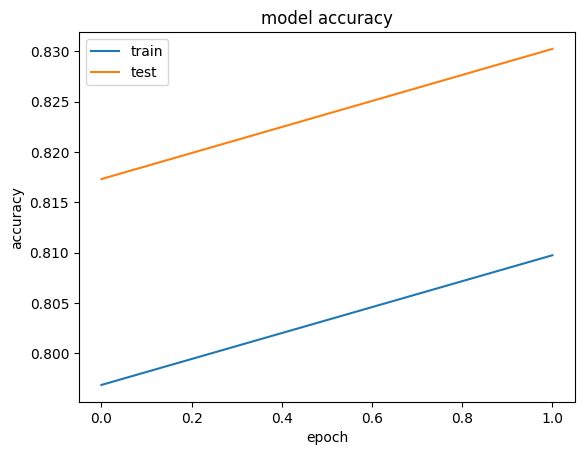

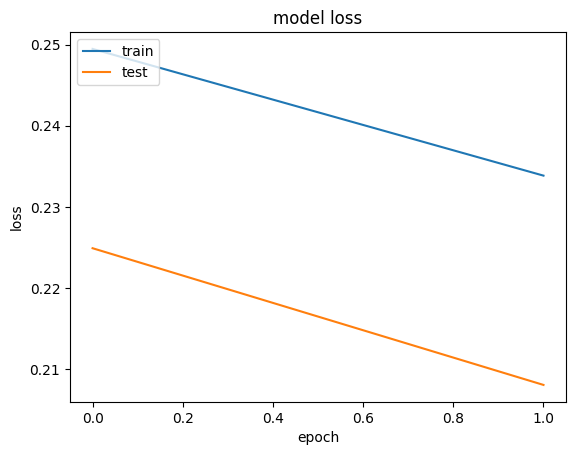

In [16]:
accr = model.evaluate(Xtest_seq_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.plot(corpus_class_model.history['acc'])
plt.plot(corpus_class_model.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(corpus_class_model.history['loss'])
plt.plot(corpus_class_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

974/974 [==============================] - 17s 18ms/step
(31145, 4)


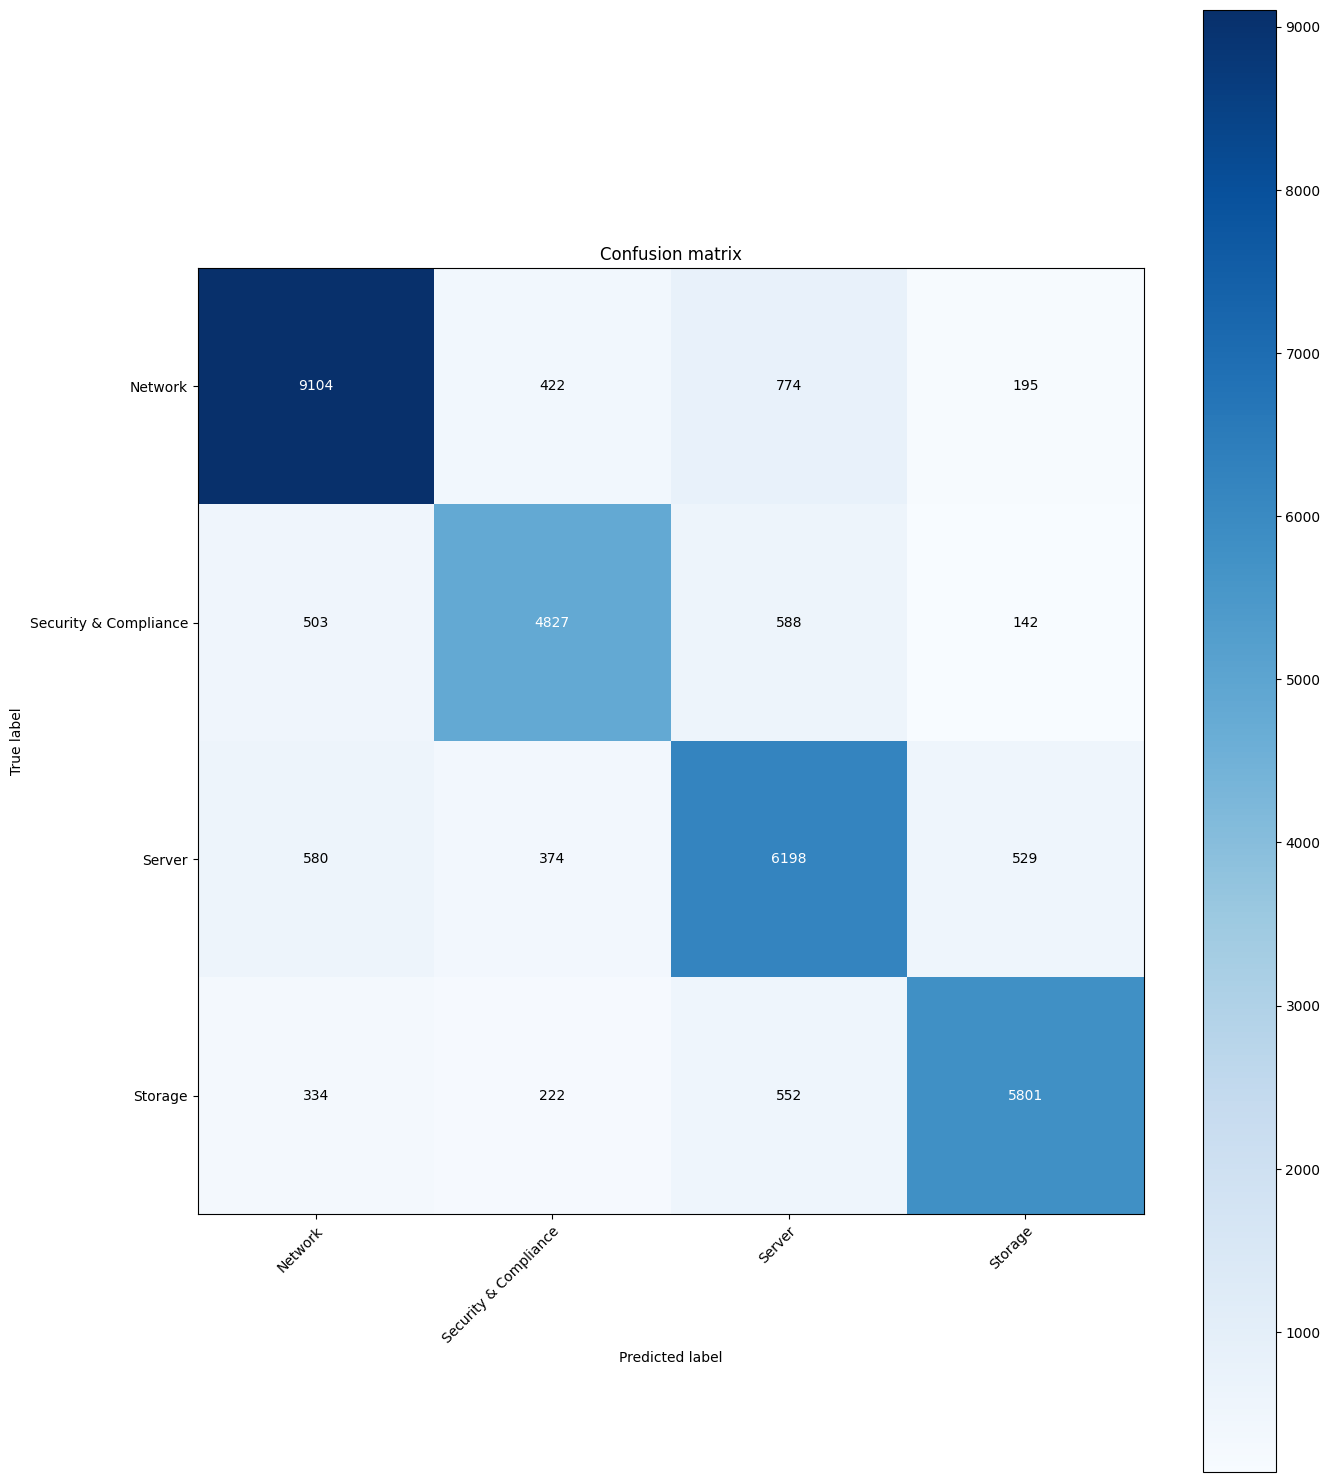

In [17]:
pred = model.predict(Xtest_seq_matrix)
print(pred.shape)
#y_pred = (predictions > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
#print(cm)
classes=corpus_labels.columns
title = 'Confusion matrix'
fig,ax = plt.subplots(figsize=(14,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
fmt = 'd'
thresh = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [18]:
model.save('model_Cat.h5')
model_json = model.to_json()
with open("model_Cat.json", "w") as json_file:
    json_file.write(model_json)    
with open('tokenizer_Cat.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
corpus_file = pd.read_csv(r"C:\Users\Mithun\Downloads\cleancorpus_6.csv")
corpus_file = corpus_file[~corpus_file['cleanLemmaText'].isna()]
corpus_file=corpus_file[['cleanLemmaText','Category']]
corpus_file=corpus_file[corpus_file['Category'].isin(['Server : Linux/Unix','Server : Windows','Server : Virtual'])]
corpus_file.reset_index(inplace=True, drop=True)
corpus_file['Category'].value_counts()

Category
Server : Linux/Unix    34075
Server : Windows       24748
Server : Virtual       22115
Name: count, dtype: int64

In [27]:
corpus_file = shuffle(corpus_file)
corpus_file.reset_index(inplace=True, drop=True)
cat_enc = pd.get_dummies(corpus_file['Category'])
corpus_enc = corpus_file.drop('Category',axis = 1)
corpus_enc = corpus_enc.join(cat_enc)
corpus_labels = corpus_enc[corpus_enc.columns[1:]]
X = list(corpus_enc['cleanLemmaText'])
y = corpus_labels.values
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.1)

In [28]:
def RNN_Subcat():
    deep_inputs = Input(name='inputs',shape=[maxlen])
    embedding_layer = Embedding(8001,64,input_length=maxlen,trainable=False)(deep_inputs)
    conv_layer = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=2)(conv_layer)
    dd = Dropout(0.2)(pool_layer)
    LSTM_layer_1 = LSTM(32,dropout=0.2,recurrent_dropout=0,bias_regularizer=L1L2(l1=0.03,l2=0.03), activation='tanh', recurrent_activation='sigmoid', use_bias=True)(dd)
    dd1 = Dropout(0.2)(LSTM_layer_1)
    dense_layer_1 = Dense(3,name='FC1',activation='sigmoid')(dd1)
    model = Model(inputs=deep_inputs,outputs=dense_layer_1)
    return model

In [29]:
tokenizer = Tokenizer(num_words=8000,oov_token='UNK')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 128
Xtrain_seq_matrix = pad_sequences(X_train_seq,maxlen=maxlen)
Xtest_seq_matrix = pad_sequences(X_test_seq,maxlen=maxlen)
model = RNN_Subcat()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 64)           512064    
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 32)           6176      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 64, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                           

In [31]:
corpus_subclass_model = model.fit(Xtrain_seq_matrix,y_train,batch_size=16,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0005)],shuffle=True)

Epoch 1/10
3643/3643 [==============================] - 18s 5ms/step - loss: 0.2437 - acc: 0.8572 - val_loss: 0.2142 - val_acc: 0.8744
Epoch 2/10
3643/3643 [==============================] - 17s 5ms/step - loss: 0.2261 - acc: 0.8689 - val_loss: 0.1929 - val_acc: 0.8855


253/253 [==============================] - 1s 2ms/step - loss: 0.1957 - acc: 0.8879
Test set
  Loss: 0.196
  Accuracy: 0.888


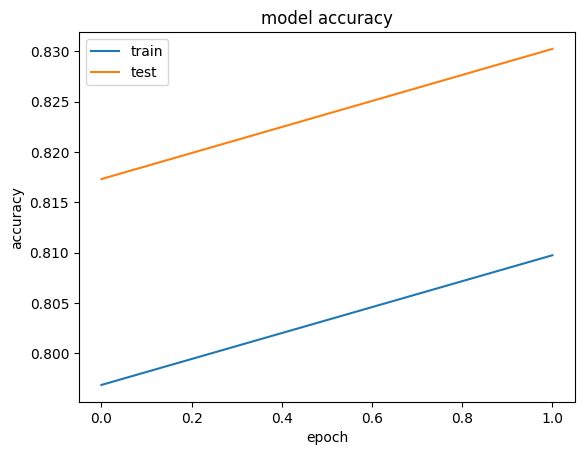

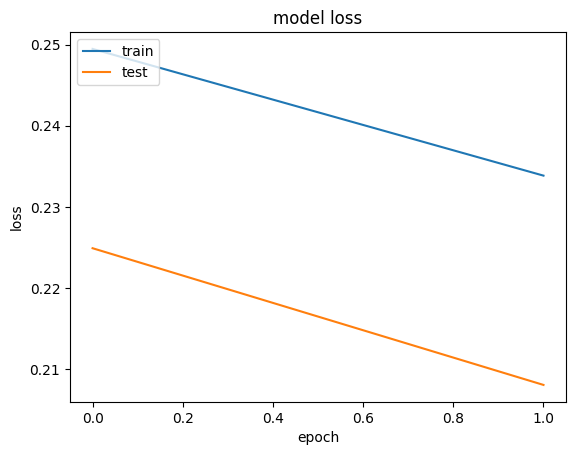

In [32]:
accr = model.evaluate(Xtest_seq_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.plot(corpus_class_model.history['acc'])
plt.plot(corpus_class_model.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(corpus_class_model.history['loss'])
plt.plot(corpus_class_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

253/253 [==============================] - 0s 2ms/step
(8094, 3)


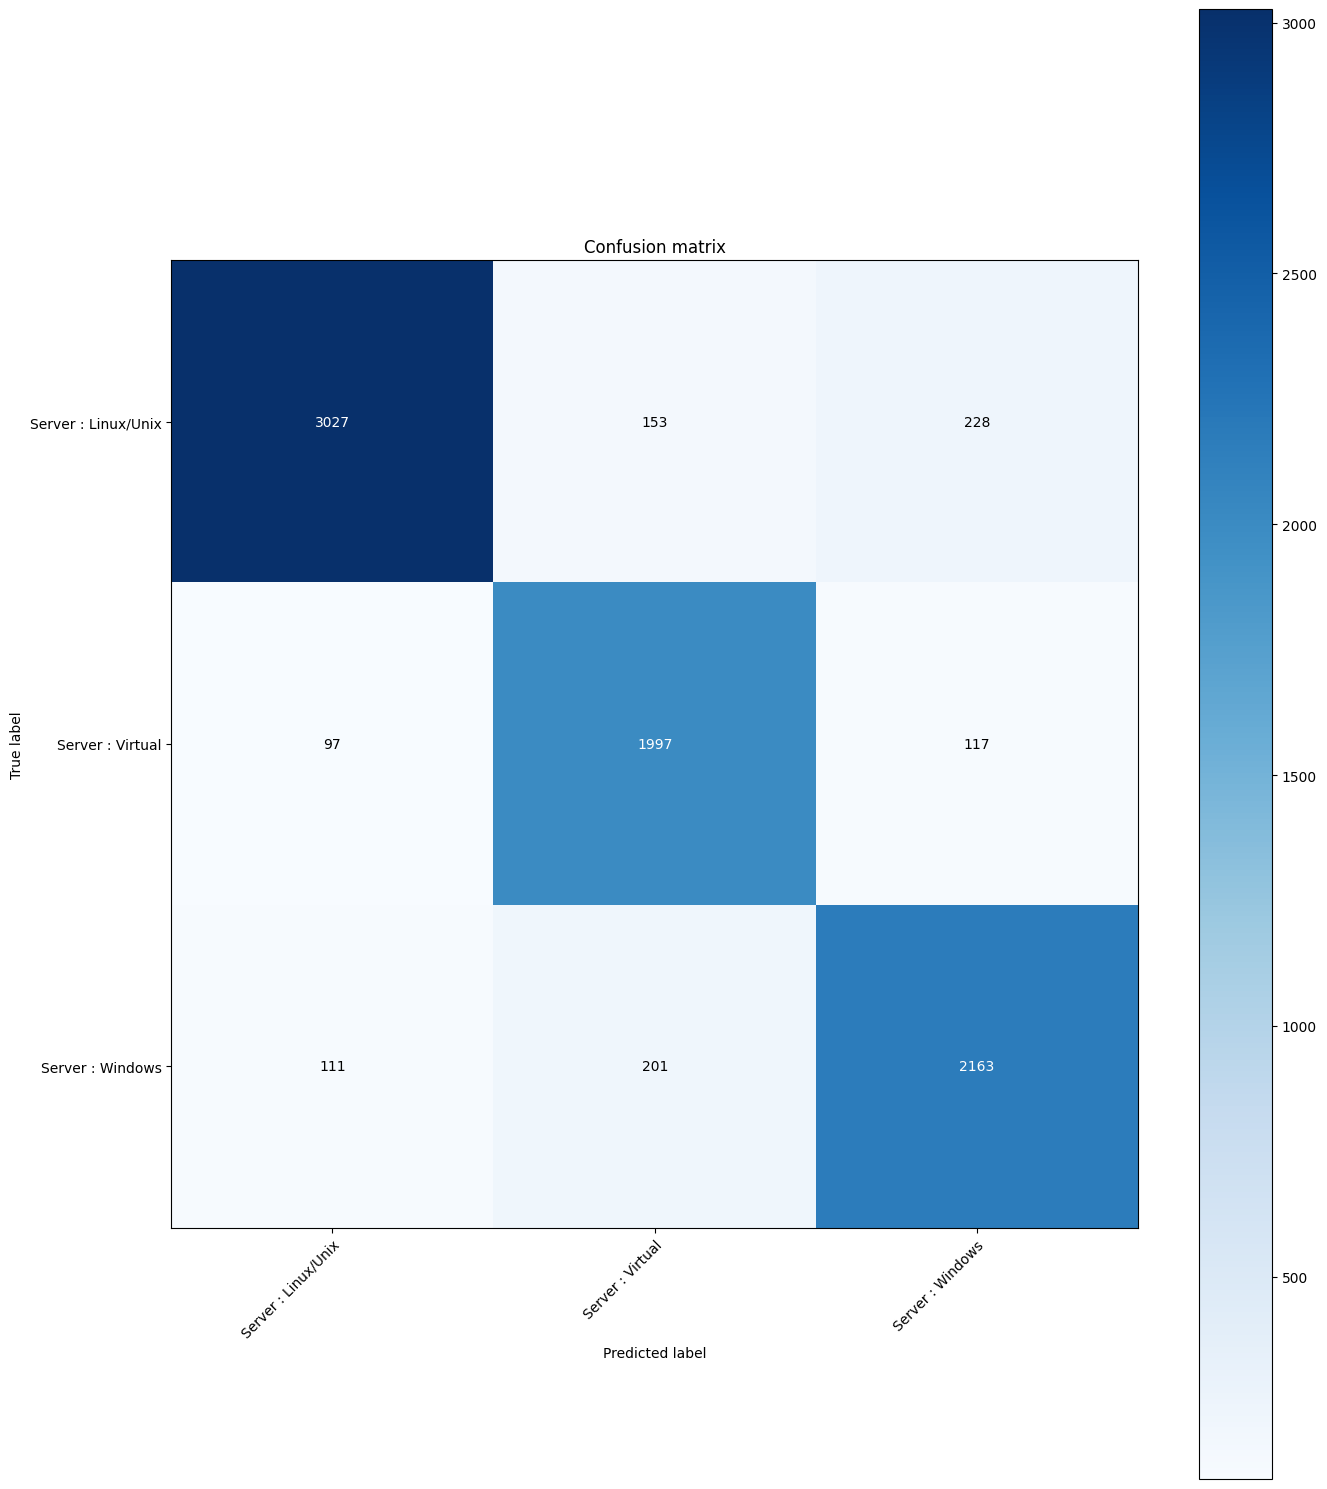

In [34]:
pred = model.predict(Xtest_seq_matrix)
print(pred.shape)
#y_pred = (predictions > 0.5)
cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
#print(cm)
classes=corpus_labels.columns
title = 'Confusion matrix'
fig,ax = plt.subplots(figsize=(14,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
fmt = 'd'
thresh = cm.max()/2
thresh = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [35]:
model.save('model_Subcat.h5')
model_json = model.to_json()
with open("model_Subcat.json", "w") as json_file:
    json_file.write(model_json)  
with open('tokenizer_Subcat.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)